## What is going on with run57? (High Av only)


CNTDIFF/run57 belongs to the experiment where I only changed the value of vertical viscosity, $A_v$. This run has the highest value of $A_v$ that I used ($10^{-3}$ m$^2$s$^{-1}$).

Although the role of viscosity is minor compared to varying vertical diffusivity or the Burger number, it is puzzling that it does not follow the trend that other runs follow for the canyon effect in CS transport and the pool impact. For example, the plots of the metrics vs $A_v$ show that when $A_v$ increases, CS also increases, except in the case of this run. However, the plots for the full canyon case and no canyon case are consistent, it is the canyon effect that does not follow.

In [18]:
import canyon_tools.savitzky_golay as sg
import matplotlib.pyplot as plt
%matplotlib inline
from netCDF4 import Dataset
import numpy as np
import seaborn as sns
import xarray as xr

In [22]:
# seaborn set-up
sns.set_context('notebook')
sns.set_style('white')
sns.set_palette('Set1')

In [65]:
def ShelfBottomField(Tr, hfac, ra, bathy, sbdepth=-152.5):
    '''Tr:some field (nt,nz,ny,nx)
       hfac: fraction of open cell at center (nz,ny,nx)
       ra: array of cell horizontal areas (ny,nx)
       bathy : depths 2D array from the grid file (ny,nx)
       sbdepth: shelf break depth (negative value)
       
       RETURNS:
       ConcFiltered = field value at cell closest to bottom (nt,ny,nx)
       Area of domain
       '''
    
    Conc = np.empty((19,360,360))
    ConcFiltered = np.empty((19,360,360))
    Area = np.empty((360,360))
    BottomInd = np.argmax(hfac[::-1,:,:]>0.0,axis=0) # start looking for first no-land cell from the bottom up.
    BottomInd = np.ones(np.shape(BottomInd))*89 - BottomInd # Get index of unreversed z axis
    
    print(np.shape(BottomInd))
    for tt in range(19):
        #print(tt)
        for j in range(360):
            for i in range(360):
                TrBottom = Tr[tt,BottomInd[i,j],i,j]
                Conc[tt,i,j] = TrBottom
                Area[i,j] = ra[i,j]
                
                    
            # Filter step noise
            ConcFiltered[tt,:,j] = sg.savitzky_golay(Conc[tt,:,j], 7,3) 
                
    maskShelf = mask2DCanyon(bathy, sbdepth)
    maskShelf = np.expand_dims(maskShelf,0) # expand along time dimension
    maskShelf = maskShelf + np.zeros(Conc.shape)
    
    return (np.ma.masked_array(ConcFiltered, mask=maskShelf),
            Area)

def ShelfField(Tr, hfac, ra, bathy, sbdepth=-152.5):
    '''Find field 2 z-levels over shelf bottom. 
       Tr:some field (nt,nz,ny,nx)
       hfac: fraction of open cell at center (nz,ny,nx)
       ra: array of cell horizontal areas (ny,nx)
       bathy : depths 2D array from the grid file (ny,nx)
       sbdepth: shelf break depth (negative value)
       
       RETURNS:
       ConcFiltered = field value at cell closest to bottom (nt,ny,nx)
       Area of domain
       '''
    
    Conc = np.empty((19,360,360))
    ConcFiltered = np.empty((19,360,360))
    Area = np.empty((360,360))
    BottomInd = np.argmax(hfac[::-1,:,:]>0.0,axis=0) # start looking for first no-land cell from the bottom up.
    BottomInd = np.ones(np.shape(BottomInd))*89 - BottomInd # Get index of unreversed z axis
    BottomIndNew = np.ones(np.shape(BottomInd))*89 - BottomInd - 2 # Get index of unreversed z axis and add 5 cells up
    
    print(np.shape(BottomInd))
    for tt in range(19):
        #print(tt)
        for j in range(360):
            for i in range(360):
                TrBottom = Tr[tt,BottomInd[i,j],i,j]
                Conc[tt,i,j] = TrBottom
                Area[i,j] = ra[i,j]
                
                    
            # Filter step noise
            ConcFiltered[tt,:,j] = sg.savitzky_golay(Conc[tt,:,j], 7,3) 
                
    maskShelf = mask2DCanyon(bathy, sbdepth)
    maskShelf = np.expand_dims(maskShelf,0) # expand along time dimension
    maskShelf = maskShelf + np.zeros(Conc.shape)
    
    return (np.ma.masked_array(ConcFiltered, mask=maskShelf),
            Area)

# ------------------------------------------------------------------------------------------------------------------------
def mask2DCanyon(bathy, sbdepth=-152.5):
    '''Mask out the canyon from the shelf.
    bathy : depths 2D array from the grid file
    sbdepth: shelf depth, always negative float 
    Returns mask'''
    
    bathyMasked = np.ma.masked_less(-bathy, -152.5)
    return(bathyMasked.mask)

# ------------------------------------------------------------------------------------------------------------------------
def unstagger_xarray(qty, index):
    """Interpolate u, v, or w component values to values at grid cell centres.
    
    Named indexing requires that input arrays are XArray DataArrays.

    :arg qty: u, v, or w component values
    :type qty: :py:class:`xarray.DataArray`
    
    :arg index: index name along which to centre
        (generally one of 'gridX', 'gridY', or 'depth')
    :type index: str

    :returns qty: u, v, or w component values at grid cell centres
    :rtype: :py:class:`xarray.DataArray`
    """
    
    qty = (qty + qty.shift(**{index: 1})) / 2
    
    return qty

In [4]:
## Set paths ##

# grid files
grid_file = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run38/gridGlob.nc'
gridNoC_file = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run42/gridGlob.nc'

# canyon files
path_38 = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run38/'
path_57 = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run57/'
path_56 = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run56/'

# no canyon files
path_42 = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run38/'
path_60 = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run60/'
path_59 = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run59/'

# filenames
fnames = {'state':'stateGlob.nc', 'ptracer':'ptracersGlob.nc','flux':'FluxTR01Glob.nc'}

In [7]:
## Open datasets ##

grid = xr.open_dataset(grid_file)
gridNoC = xr.open_dataset(gridNoC_file)

state38 = xr.open_dataset(path_38+fnames['state'])
state56 = xr.open_dataset(path_56+fnames['state'])
state57 = xr.open_dataset(path_57+fnames['state'])

state42 = xr.open_dataset(path_42+fnames['state'])
state59 = xr.open_dataset(path_59+fnames['state'])
state60 = xr.open_dataset(path_60+fnames['state'])

ptracer38 = xr.open_dataset(path_38+fnames['ptracer'])
ptracer56 = xr.open_dataset(path_56+fnames['ptracer'])
ptracer57 = xr.open_dataset(path_57+fnames['ptracer'])

ptracer42 = xr.open_dataset(path_42+fnames['ptracer'])
ptracer59 = xr.open_dataset(path_59+fnames['ptracer'])
ptracer60 = xr.open_dataset(path_60+fnames['ptracer'])

flux38 = xr.open_dataset(path_38+fnames['flux'])
flux56 = xr.open_dataset(path_56+fnames['flux'])
flux57 = xr.open_dataset(path_57+fnames['flux'])

flux42 = xr.open_dataset(path_42+fnames['flux'])
flux59 = xr.open_dataset(path_59+fnames['flux'])
flux60 = xr.open_dataset(path_60+fnames['flux'])

### Tracer near shelf bottom

In [61]:
Conc38, Area38 = ShelfBottomField(ptracer38.Tr1.data, grid.HFacC.data, grid.rA.data, grid.Depth.data)
Conc56, Area56 = ShelfBottomField(ptracer56.Tr1.data, grid.HFacC.data, grid.rA.data, grid.Depth.data)
Conc57, Area57 = ShelfBottomField(ptracer57.Tr1.data, grid.HFacC.data, grid.rA.data, grid.Depth.data)

(360, 360)


/home/kramosmu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(360, 360)
(360, 360)


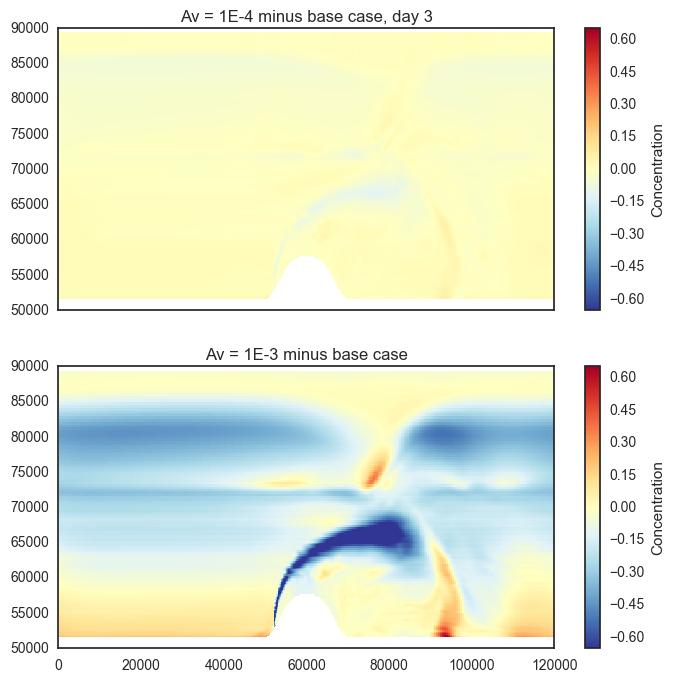

In [62]:
fig,ax = plt.subplots(2,1,figsize=(8,8), sharey=True,sharex=True)

t1 = 6
yslice = slice(227,359)

maxC = (Conc57[t1,yslice,:].data-Conc38[t1,yslice,:].data).max()
minC = -maxC

pcol1 =ax[0].pcolor(grid.X,grid.Y.isel(Y=yslice),Conc56[t1,yslice,:]-Conc38[t1,yslice,:], vmax=maxC,vmin=minC, cmap='RdYlBu_r')
cbar1 = plt.colorbar(pcol1,ax=ax[0])
cbar1.set_label('Concentration')
ax[0].set_title('Av = 1E-4 minus base case, day 3')


pcol2 =ax[1].pcolor(grid.X,grid.Y.isel(Y=yslice),Conc57[t1,yslice,:]-Conc38[t1,yslice,:], vmax=maxC,vmin=minC, cmap='RdYlBu_r')
cbar2 = plt.colorbar(pcol2,ax=ax[1])
ax[1].set_title('Av = 1E-3 minus base case')
cbar2.set_label('Concentration')

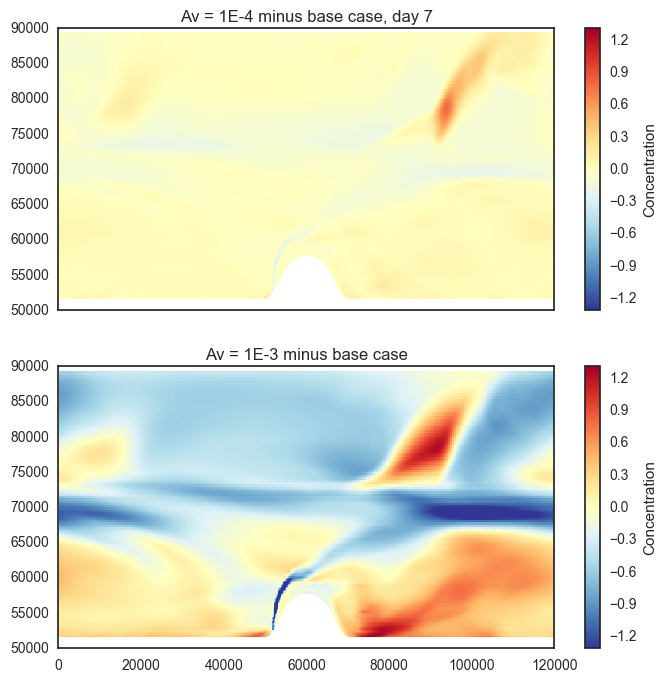

In [63]:
fig,ax = plt.subplots(2,1,figsize=(8,8), sharey=True,sharex=True)

t1 = 14
yslice = slice(227,359)

maxC = (Conc57[t1,yslice,:].data-Conc38[t1,yslice,:].data).max()
minC = -maxC

pcol1 =ax[0].pcolor(grid.X,grid.Y.isel(Y=yslice),Conc56[t1,yslice,:]-Conc38[t1,yslice,:], vmax=maxC,vmin=minC, cmap='RdYlBu_r')
cbar1 = plt.colorbar(pcol1,ax=ax[0])
cbar1.set_label('Concentration')
ax[0].set_title('Av = 1E-4 minus base case, day 7')


pcol2 =ax[1].pcolor(grid.X,grid.Y.isel(Y=yslice),Conc57[t1,yslice,:]-Conc38[t1,yslice,:], vmax=maxC,vmin=minC, cmap='RdYlBu_r')
cbar2 = plt.colorbar(pcol2,ax=ax[1])
ax[1].set_title('Av = 1E-3 minus base case')
cbar2.set_label('Concentration')

### Velocities

In [67]:
V38, Area38 = ShelfField(unstagger_xarray(state38.V,'Yp1').data, grid.HFacC.data, grid.rA.data, grid.Depth.data)
V56, Area56 = ShelfField(unstagger_xarray(state56.V,'Yp1').data, grid.HFacC.data, grid.rA.data, grid.Depth.data)
V57, Area57 = ShelfField(unstagger_xarray(state57.V,'Yp1').data, grid.HFacC.data, grid.rA.data, grid.Depth.data)

U38, Area38 = ShelfField(unstagger_xarray(state38.U,'Xp1').data, grid.HFacC.data, grid.rA.data, grid.Depth.data)
U56, Area56 = ShelfField(unstagger_xarray(state56.U,'Xp1').data, grid.HFacC.data, grid.rA.data, grid.Depth.data)
U57, Area57 = ShelfField(unstagger_xarray(state57.U,'Xp1').data, grid.HFacC.data, grid.rA.data, grid.Depth.data)

(360, 360)


/home/kramosmu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:64: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(360, 360)
(360, 360)
(360, 360)
(360, 360)
(360, 360)


## 2 z levels over shelf bottom

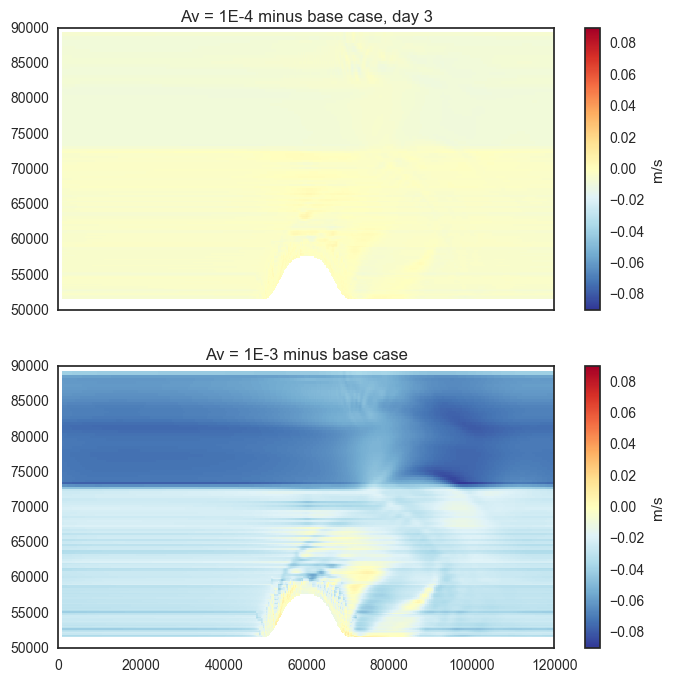

In [75]:
t1 = 6
yslice = slice(227,359)

spd38 = (((U38[t1,:,slice(0,360)])**2)+(V38[t1,:,slice(0,360)])**2)**(0.5)
spd57 = (((U57[t1,:,slice(0,360)])**2)+(V57[t1,:,slice(0,360)])**2)**(0.5)
spd56 = (((U56[t1,:,slice(0,360)])**2)+(V56[t1,:,slice(0,360)])**2)**(0.5)

fig,ax = plt.subplots(2,1,figsize=(8,8), sharey=True,sharex=True)

maxC = -minC
minC = (spd57[yslice,:]-spd38[yslice,:]).min()

pcol1 =ax[0].pcolor(grid.X,grid.Y.isel(Y=yslice),spd56[yslice,:]-spd38[yslice,:], vmax=maxC,vmin=minC, cmap='RdYlBu_r')
cbar1 = plt.colorbar(pcol1,ax=ax[0])
cbar1.set_label('m/s')
ax[0].set_title('Av = 1E-4 minus base case, day 3')


pcol2 =ax[1].pcolor(grid.X,grid.Y.isel(Y=yslice),spd57[yslice,:]-spd38[yslice,:], vmax=maxC,vmin=minC, cmap='RdYlBu_r')
cbar2 = plt.colorbar(pcol2,ax=ax[1])
ax[1].set_title('Av = 1E-3 minus base case')
cbar2.set_label('m/s')

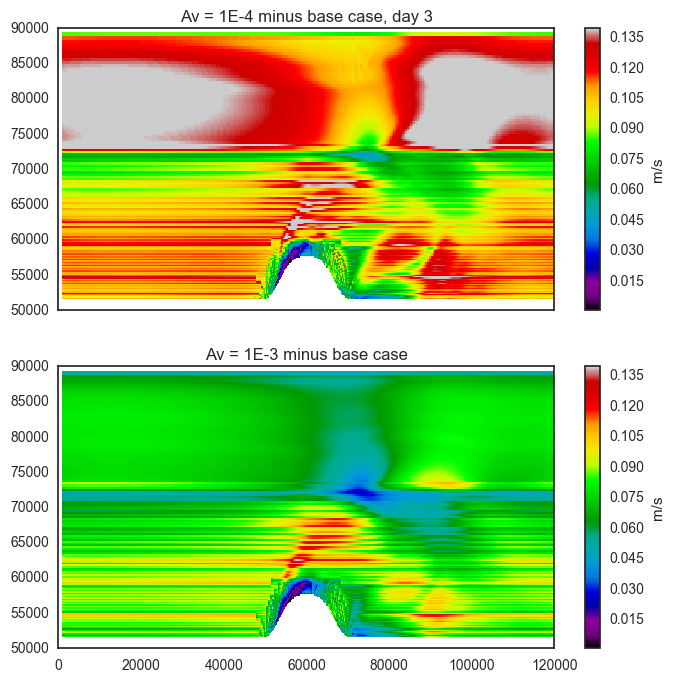

In [76]:
t1 = 6
yslice = slice(227,359)

fig,ax = plt.subplots(2,1,figsize=(8,8), sharey=True,sharex=True)

maxC = (spd57[yslice,:]).max()
minC = (spd57[yslice,:]).min()

pcol1 =ax[0].pcolor(grid.X,grid.Y.isel(Y=yslice),spd56[yslice,:], vmax=maxC,vmin=minC, cmap='spectral')
cbar1 = plt.colorbar(pcol1,ax=ax[0])
cbar1.set_label('m/s')
ax[0].set_title('Av = 1E-4 minus base case, day 3')


pcol2 =ax[1].pcolor(grid.X,grid.Y.isel(Y=yslice),spd57[yslice,:], vmax=maxC,vmin=minC, cmap='spectral')
cbar2 = plt.colorbar(pcol2,ax=ax[1])
ax[1].set_title('Av = 1E-3 minus base case')
cbar2.set_label('m/s')

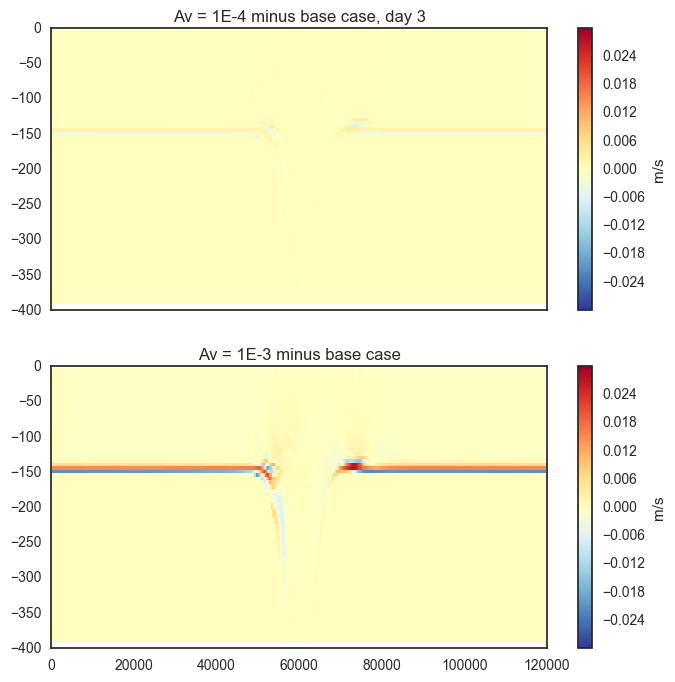

In [48]:
tindex = 3
V38 = unstagger_xarray(state38.V.isel(T=tindex),'Yp1')
V56 = unstagger_xarray(state56.V.isel(T=tindex),'Yp1')
V57 = unstagger_xarray(state57.V.isel(T=tindex),'Yp1')

fig,ax = plt.subplots(2,1,figsize=(8,8), sharey=True,sharex=True)

yindex = 227
zslice = slice(0,50)

maxC = (V57[t1,yslice,:].data-V38[t1,yslice,:].data).max()
minC = -maxC

pcol1 =ax[0].pcolor(grid.X,grid.Z.isel(Z=zslice),V56[zslice,yindex,:].data-V38[zslice,yindex,:].data, vmax=maxC,vmin=minC, cmap='RdYlBu_r')
cbar1 = plt.colorbar(pcol1,ax=ax[0])
cbar1.set_label('m/s')
ax[0].set_title('Av = 1E-4 minus base case, day 3')


pcol2 =ax[1].pcolor(grid.X,grid.Z.isel(Z=zslice),V57[zslice,yindex,:].data-V38[zslice,yindex,:].data, vmax=maxC,vmin=minC, cmap='RdYlBu_r')
cbar2 = plt.colorbar(pcol2,ax=ax[1])
ax[1].set_title('Av = 1E-3 minus base case')
cbar2.set_label('m/s')

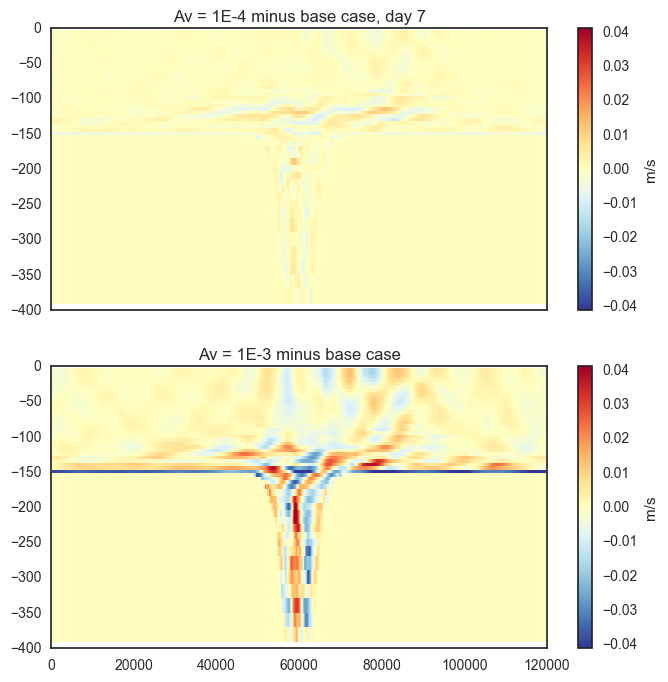

In [49]:
tindex = 14
V38 = unstagger_xarray(state38.V.isel(T=tindex),'Yp1')
V56 = unstagger_xarray(state56.V.isel(T=tindex),'Yp1')
V57 = unstagger_xarray(state57.V.isel(T=tindex),'Yp1')

fig,ax = plt.subplots(2,1,figsize=(8,8), sharey=True,sharex=True)

yindex = 227
zslice = slice(0,50)

maxC = (V57[t1,yslice,:].data-V38[t1,yslice,:].data).max()
minC = -maxC

pcol1 =ax[0].pcolor(grid.X,grid.Z.isel(Z=zslice),V56[zslice,yindex,:].data-V38[zslice,yindex,:].data, vmax=maxC,vmin=minC, cmap='RdYlBu_r')
cbar1 = plt.colorbar(pcol1,ax=ax[0])
cbar1.set_label('m/s')
ax[0].set_title('Av = 1E-4 minus base case, day 7')


pcol2 =ax[1].pcolor(grid.X,grid.Z.isel(Z=zslice),V57[zslice,yindex,:].data-V38[zslice,yindex,:].data, vmax=maxC,vmin=minC, cmap='RdYlBu_r')
cbar2 = plt.colorbar(pcol2,ax=ax[1])
ax[1].set_title('Av = 1E-3 minus base case')
cbar2.set_label('m/s')

In [77]:
path_45 = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run45/'
state45 = xr.open_dataset(path_45+fnames['state'])


In [78]:
state45

<xarray.Dataset>
Dimensions:  (T: 19, X: 360, Xp1: 361, Y: 360, Yp1: 361, Z: 90, Zl: 90)
Coordinates:
  * T        (T) float64 0.0 4.32e+04 8.64e+04 1.296e+05 1.728e+05 2.16e+05 ...
  * X        (X) float64 314.9 944.3 1.573e+03 2.199e+03 2.823e+03 3.444e+03 ...
  * Xp1      (Xp1) float64 0.0 629.8 1.259e+03 1.886e+03 2.512e+03 3.134e+03 ...
  * Y        (Y) float64 218.6 655.7 1.092e+03 1.528e+03 1.962e+03 2.395e+03 ...
  * Yp1      (Yp1) float64 0.0 437.2 874.1 1.31e+03 1.745e+03 2.179e+03 ...
  * Z        (Z) float64 -2.5 -7.5 -12.5 -17.5 -22.5 -27.5 -32.5 -37.5 -42.5 ...
  * Zl       (Zl) float64 0.0 -5.0 -10.0 -15.0 -20.0 -25.0 -30.0 -35.0 -40.0 ...
Data variables:
    Eta      (T, Y, X) float32 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    S        (T, Z, Y, X) float32 32.0 32.0 32.0 32.0 32.0 32.0 32.0 32.0 ...
    Temp     (T, Z, Y, X) float32 20.0 20.0 20.0 20.0 20.0 20.0 20.0 20.0 ...
    U        (T, Z, Y, Xp1) float32 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    V 

In [79]:
state45.T

<xarray.Dataset>
Dimensions:  (T: 19, X: 360, Xp1: 361, Y: 360, Yp1: 361, Z: 90, Zl: 90)
Coordinates:
  * T        (T) float64 0.0 4.32e+04 8.64e+04 1.296e+05 1.728e+05 2.16e+05 ...
  * X        (X) float64 314.9 944.3 1.573e+03 2.199e+03 2.823e+03 3.444e+03 ...
  * Xp1      (Xp1) float64 0.0 629.8 1.259e+03 1.886e+03 2.512e+03 3.134e+03 ...
  * Y        (Y) float64 218.6 655.7 1.092e+03 1.528e+03 1.962e+03 2.395e+03 ...
  * Yp1      (Yp1) float64 0.0 437.2 874.1 1.31e+03 1.745e+03 2.179e+03 ...
  * Z        (Z) float64 -2.5 -7.5 -12.5 -17.5 -22.5 -27.5 -32.5 -37.5 -42.5 ...
  * Zl       (Zl) float64 0.0 -5.0 -10.0 -15.0 -20.0 -25.0 -30.0 -35.0 -40.0 ...
Data variables:
    Eta      (X, Y, T) float32 0.0 nan nan nan nan nan nan nan nan nan nan ...
    S        (X, Y, Z, T) float32 32.0 nan nan nan nan nan nan nan nan nan ...
    Temp     (X, Y, Z, T) float32 20.0 nan nan nan nan nan nan nan nan nan ...
    U        (Xp1, Y, Z, T) float32 0.0 nan nan nan nan nan nan nan nan nan ...
    